# EDA

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from glob import glob
import matplotlib.image as mpimg
import os.path as osp
import os
import random
import itertools

INPUT = "input"

In [2]:
class_df = pd.read_csv(osp.join(INPUT, "class.csv")) # 96 classes and 23 clusters
id2index = dict()
for key, v1, v2, v3 in zip(class_df['id'], class_df['cluster_id'], class_df['intra_cluster_id'], class_df['class_id']):
    id2index[key] = (v1, v2, v3) # (clu_id, intra_clu_id, cls_id)

num_cluster = len(class_df['cluster_id'].unique())
num_classes = []
for c in range(num_cluster):
    num_classes.append(len(class_df[class_df['cluster_id'] == c]))

cluster_names = []
class_names = []
for c in range(num_cluster):
    cluster_names.append(class_df[class_df['cluster_id'] == c].iloc[0]['class_name'])

for c in range(sum(num_classes)):
    class_names.append(class_df[class_df['class_id'] == c]['class_name'].item())

cls_mapper = dict()
for v1, v2, v3 in zip(class_df["cluster_id"], class_df["intra_cluster_id"], class_df["class_id"]):
    cls_mapper[(v1, v2)] = v3
    

In [3]:
def get_random_image(class_df, cluid, claid):
    class_id = class_df[(class_df["cluster_id"] == cluid) & (class_df["intra_cluster_id"] == claid)]["id"].item()
    image_files = glob(osp.join(INPUT, "train", class_id, "*.JPEG"))
    file = random.choice(image_files)
    return mpimg.imread(file)

def get_title(class_df, cluid, claid):
    return class_df[(class_df["cluster_id"] == cluid) & (class_df["intra_cluster_id"] == claid)]["class_name"].item()

In [4]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=6, figsize=(20, 10), title_fontsize=15):
    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

Cluster : 0


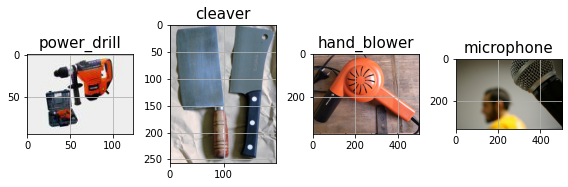

Cluster : 1


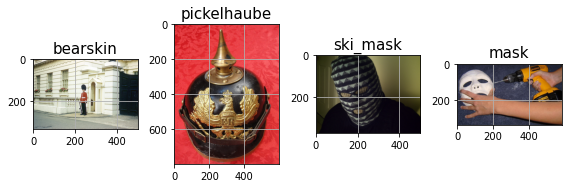

Cluster : 2


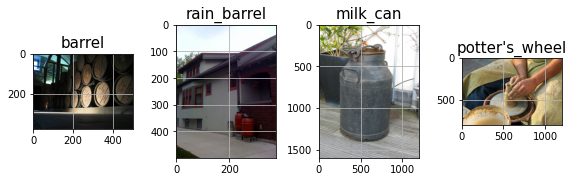

Cluster : 3


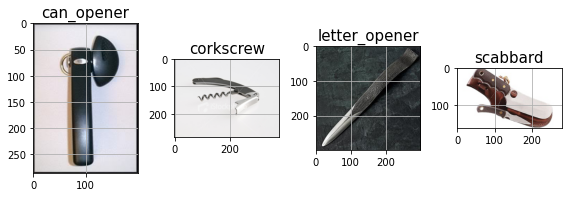

Cluster : 4


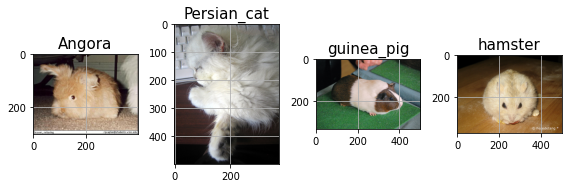

Cluster : 5


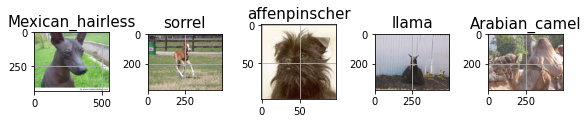

Cluster : 6


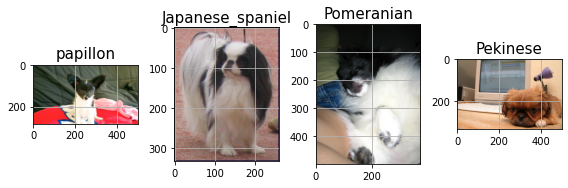

Cluster : 7


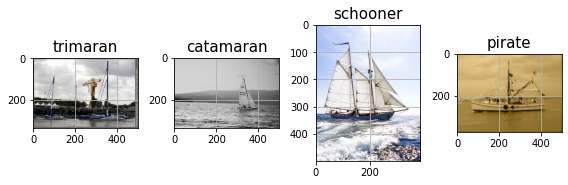

Cluster : 8


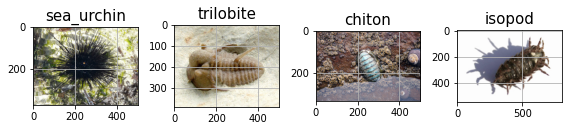

Cluster : 9


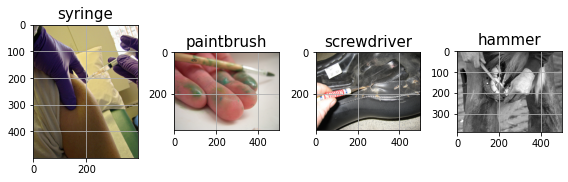

Cluster : 10


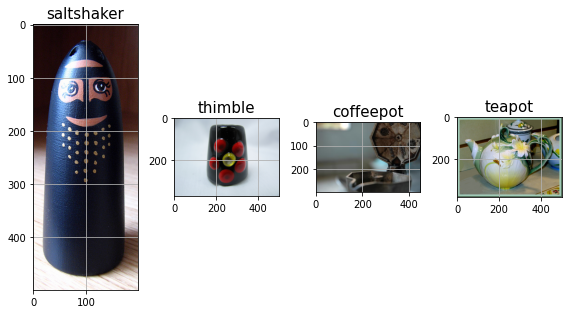

Cluster : 11


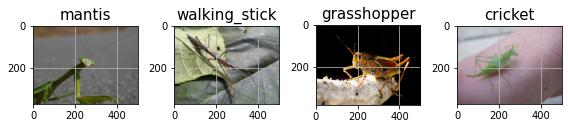

Cluster : 12


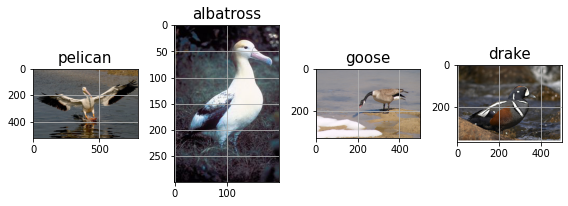

Cluster : 13


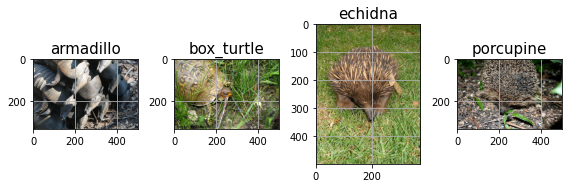

Cluster : 14


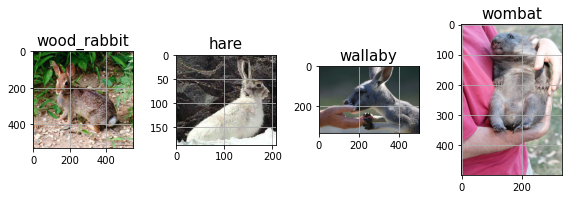

Cluster : 15


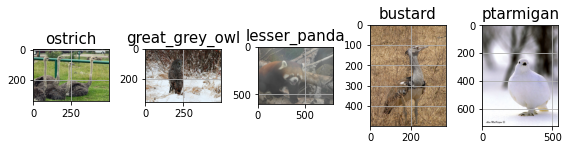

Cluster : 16


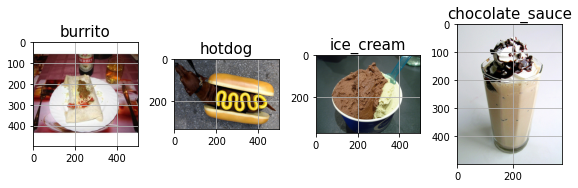

Cluster : 17


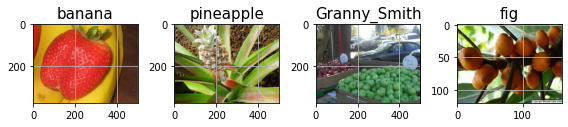

Cluster : 18


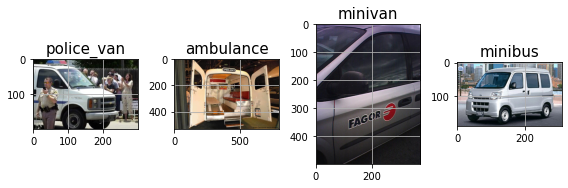

Cluster : 19


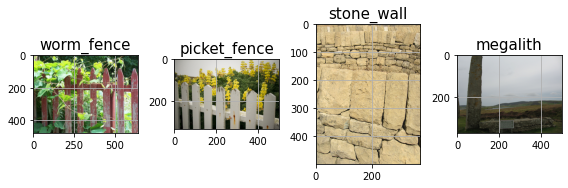

Cluster : 20


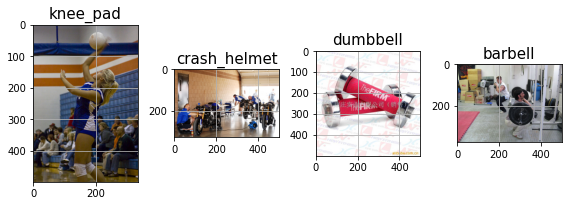

Cluster : 21


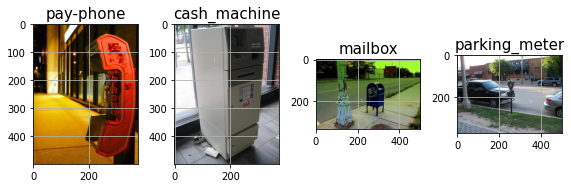

Cluster : 22


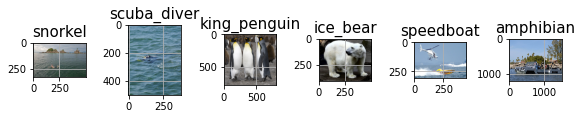

In [5]:
for c in range(num_cluster):
    list_images = [get_random_image(class_df, c, i) for i in range(num_classes[c])]
    list_title = [get_title(class_df, c, i) for i in range(num_classes[c])]
    print("Cluster :", c)
    show_image_list(list_images, list_title, figsize=(8, 8))

In [6]:
class Evaluator:
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class
        self.reset()
        
    def _generate_matrix(self, target, pred):
        np_target = target.cpu().detach().numpy() if torch.is_tensor(target) else target
        np_pred = pred.cpu().detach().numpy() if torch.is_tensor(pred) else pred
        label = self.num_class *np_target + np_pred
        count = np.bincount(label, minlength=self.num_class**2)
        confusion_matrix = count.reshape(self.num_class, self.num_class)
        return confusion_matrix
        
    def add_batch(self, gt_image, pre_image):
        assert gt_image.shape == pre_image.shape
        self.confusion_matrix = self.confusion_matrix + self._generate_matrix(gt_image, pre_image)

    def reset(self):
        self.confusion_matrix = np.zeros((self.num_class, self.num_class), int)
        
    def get_confusion_matrix(self):
        return self.confusion_matrix


def log_confusion_matrix(writer, tag, confusion_matrix, class_names=None, step=None):
    if torch.is_tensor(confusion_matrix):
        CM = confusion_matrix.cpu().detach().numpy()
    else:
        CM = confusion_matrix
    figure = plot_confusion_matrix(CM, class_names)
    image = plot_to_image(figure)
    writer.add_image(tag, 
                     img_tensor=image, 
                     global_step=step,
                     dataformats="HWC"
                     )

def plot_confusion_matrix(cm, class_names=None):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    if class_names is None:
        class_names = np.arange(len(cm))
    figure = plt.figure(figsize=(8, 8), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=4)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        # label = "-" if np.isnan(labels[i, j]) else labels[i, j]
        # plt.text(j, i, label, horizontalalignment="center", color=color)
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure


In [7]:
from model import get_model, MultiheadResNet, AuxResNet
from augmentation import get_augmentation
from data import InferenceDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch.utils.data import DataLoader

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
_, valid_transform = get_augmentation()
dataset = InferenceDataset(INPUT, "valid", transform=valid_transform)
loader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
val_df = pd.read_csv(osp.join(INPUT, "val_gt.csv"))
targets = val_df["class_id"].values

# Baseline Eval

100%|██████████| 600/600 [00:07<00:00, 80.76it/s] 


#####  Baseline Model (ResNet18)  #####
Accuracy : 85.91666666666666%


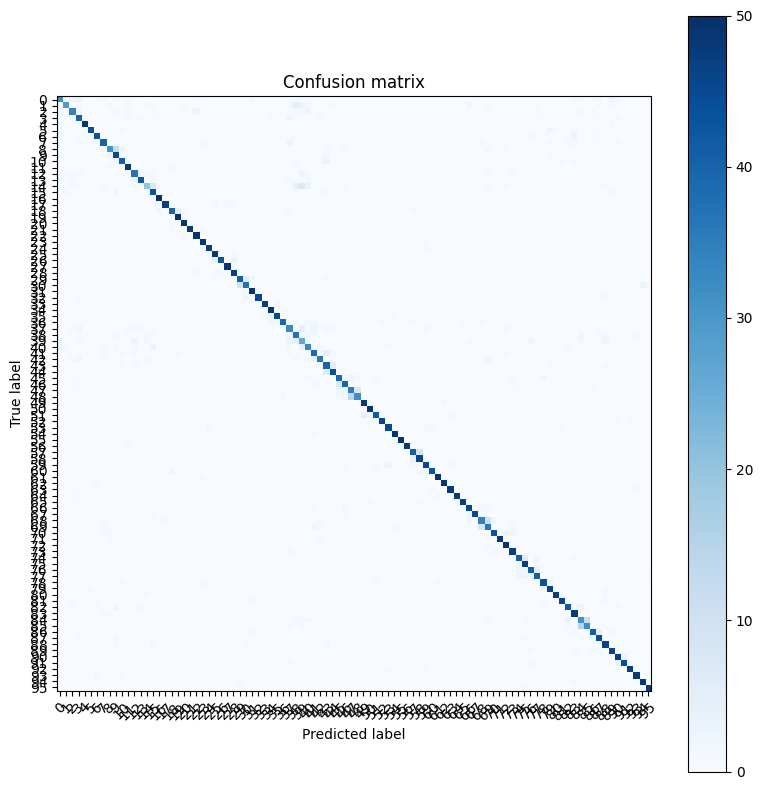

In [9]:
model = get_model("resnet18", num_class=sum(num_classes), pretrained=False)
model.to(device)
model.eval()
ckpt = torch.load("records/baseline_resnet18_lr_0.001_bs_64_pretrained/model_best.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict(ckpt["state_dict"])
evaluator = Evaluator(sum(num_classes))
preds = []
for images in tqdm(loader):
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
        _, pred = torch.max(output, 1)
    
    preds += pred.cpu().detach().tolist()

preds = np.array(preds)
evaluator.add_batch(targets, preds)
print("#####  Baseline Model (ResNet18)  #####")
print("Accuracy : {}%".format(accuracy_score(targets, preds) * 100)) # 85.917%
plot_confusion_matrix(evaluator.get_confusion_matrix())
del model, ckpt

100%|██████████| 600/600 [00:08<00:00, 73.90it/s]


#####  Baseline Model (ResNet50)  #####
Accuracy : 89.79166666666667%


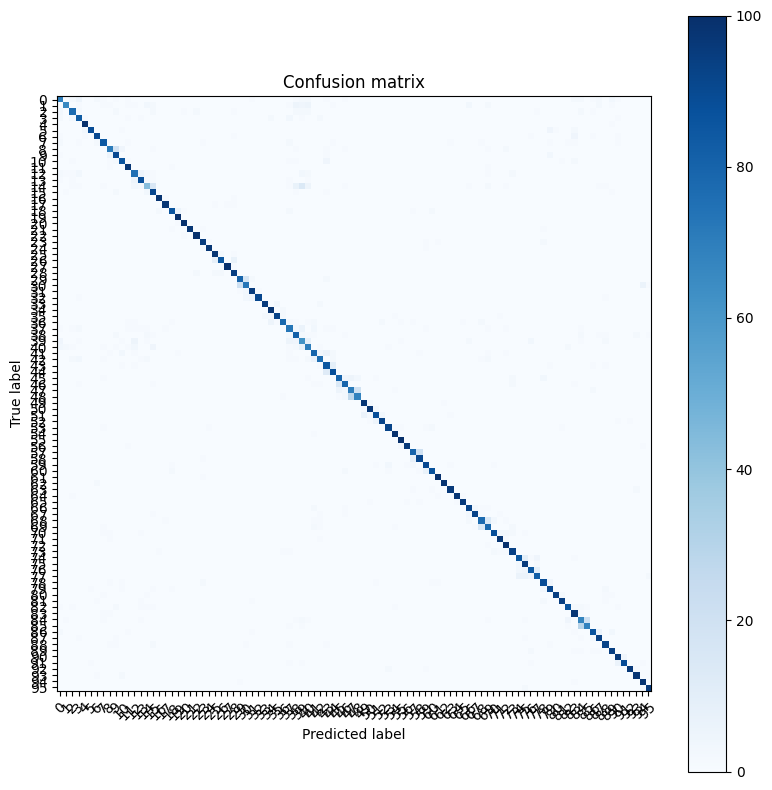

In [10]:
model = get_model("resnet50", num_class=sum(num_classes), pretrained=False)
model.to(device)
model.eval()
ckpt = torch.load("records/baseline_resnet50_lr_0.001_bs_64_pretrained/model_best.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict(ckpt["state_dict"])
preds = []
for images in tqdm(loader):
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
        _, pred = torch.max(output, 1)
    preds += pred.cpu().detach().tolist()

preds = np.array(preds)
evaluator.add_batch(targets, preds)
print("#####  Baseline Model (ResNet50)  #####")
print("Accuracy : {}%".format(accuracy_score(targets, preds) * 100)) # 89.792%
# print(classification_report(targets, preds, target_names=class_names))
plot_confusion_matrix(evaluator.get_confusion_matrix())
del model, ckpt

# Two-Stage Eval

100%|██████████| 600/600 [00:31<00:00, 18.95it/s]


#####  Two-Stage Model (ResNet50+ResNet18)  #####
Accuracy : 87.16666666666667%


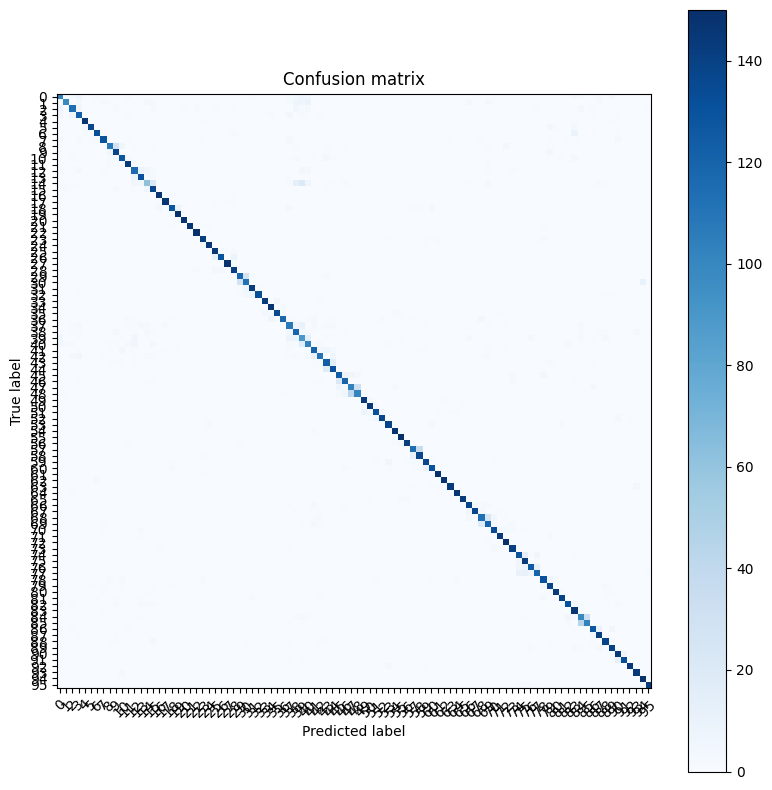

In [11]:
stage1_model = get_model("resnet50", num_class=num_cluster, pretrained=False)
stage1_model.to(device)
stage1_model.eval()
stage2_model = MultiheadResNet("resnet18", num_cluster=num_cluster, num_classes=num_classes, pretrained=False)
stage2_model.to(device)
stage2_model.eval()

ckpt = torch.load("records/stage2_resnet50-18_lr_0.002_bs_128_pretrained/model_best.pth.tar", map_location=torch.device('cpu'))
stage1_model.load_state_dict(ckpt["stage1"]["state_dict"])
stage2_model.load_state_dict(ckpt["stage2"]["state_dict"])
preds = []
for images in tqdm(loader):
    images = images.to(device)
    for i in range(images.size(0)):
        image = images[[i]]
        with torch.no_grad():
            output = stage1_model(image)
            _, cluster_pred = torch.max(output, 1)
            output, _ = stage2_model(image, cluster_pred)
            output = output[cluster_pred.item()]
            _, intra_pred = torch.max(output, 1)
        
        preds.append(cls_mapper[(cluster_pred.item(), intra_pred.item())])

preds = np.array(preds)
evaluator.add_batch(targets, preds)
print("#####  Two-Stage Model (ResNet50+ResNet18)  #####")
print("Accuracy : {}%".format(accuracy_score(targets, preds) * 100)) # 87.167%
# print(classification_report(targets, preds, target_names=class_names))
plot_confusion_matrix(evaluator.get_confusion_matrix())
del stage1_model, stage2_model, ckpt

100%|██████████| 600/600 [00:41<00:00, 14.40it/s]


#####  Two-Stage Model (ResNet50+ResNet50)  #####
Accuracy : 88.52083333333334%


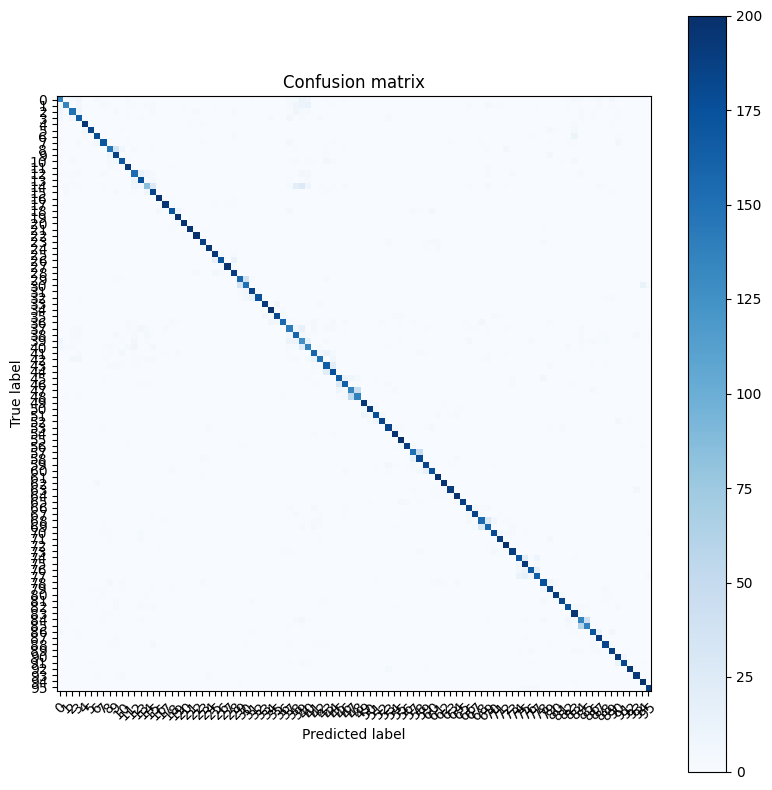

In [12]:
stage1_model = get_model("resnet50", num_class=num_cluster, pretrained=False)
stage1_model.to(device)
stage1_model.eval()
stage2_model = MultiheadResNet("resnet50", num_cluster=num_cluster, num_classes=num_classes, pretrained=False)
stage2_model.to(device)
stage2_model.eval()

ckpt = torch.load("records/stage2_resnet50-50_lr_0.002_bs_128_pretrained/model_best.pth.tar", map_location=torch.device('cpu'))
stage1_model.load_state_dict(ckpt["stage1"]["state_dict"])
stage2_model.load_state_dict(ckpt["stage2"]["state_dict"])
preds = []
for images in tqdm(loader):
    images = images.to(device)
    for i in range(images.size(0)):
        image = images[[i]]
        with torch.no_grad():
            output = stage1_model(image)
            _, cluster_pred = torch.max(output, 1)
            output, _ = stage2_model(image, cluster_pred)
            output = output[cluster_pred.item()]
            _, intra_pred = torch.max(output, 1)
        
        preds.append(cls_mapper[(cluster_pred.item(), intra_pred.item())])

preds = np.array(preds)
evaluator.add_batch(targets, preds)
print("#####  Two-Stage Model (ResNet50+ResNet50)  #####")
print("Accuracy : {}%".format(accuracy_score(targets, preds) * 100))
# print(classification_report(targets, preds, target_names=class_names))
plot_confusion_matrix(evaluator.get_confusion_matrix())
del stage1_model, stage2_model, ckpt

# Two-headed Eval

100%|██████████| 600/600 [00:07<00:00, 79.92it/s]


#####  Two-Headed Model (ResNet18)  #####
Accuracy : 85.64583333333333%


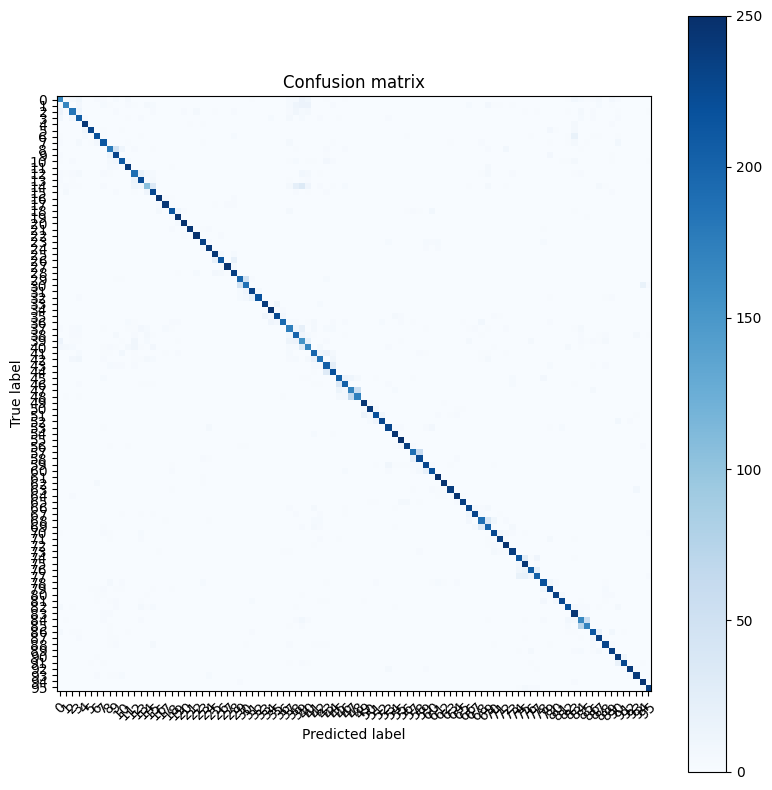

In [13]:
model = AuxResNet("resnet18", num_cluster=num_cluster, num_class=sum(num_classes), pretrained=False)
model.to(device)
model.eval()
ckpt = torch.load("records/auxiliary_ratio0.25_resnet18_lr_0.001_bs_64_pretrained/model_best.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict(ckpt["state_dict"])
preds = []
for images in tqdm(loader):
    images = images.to(device)
    with torch.no_grad():
        output, _ = model(images)
        _, pred = torch.max(output, 1)
    preds += pred.cpu().detach().tolist()

preds = np.array(preds)
evaluator.add_batch(targets, preds)
print("#####  Two-Headed Model (ResNet18)  #####")
print("Accuracy : {}%".format(accuracy_score(targets, preds) * 100)) # 85.645%
# print(classification_report(targets, preds, target_names=class_names))
plot_confusion_matrix(evaluator.get_confusion_matrix())
del model, ckpt

100%|██████████| 600/600 [00:08<00:00, 72.36it/s]


#####  Two-Headed Model (ResNet50)  #####
Accuracy : 89.22916666666667%


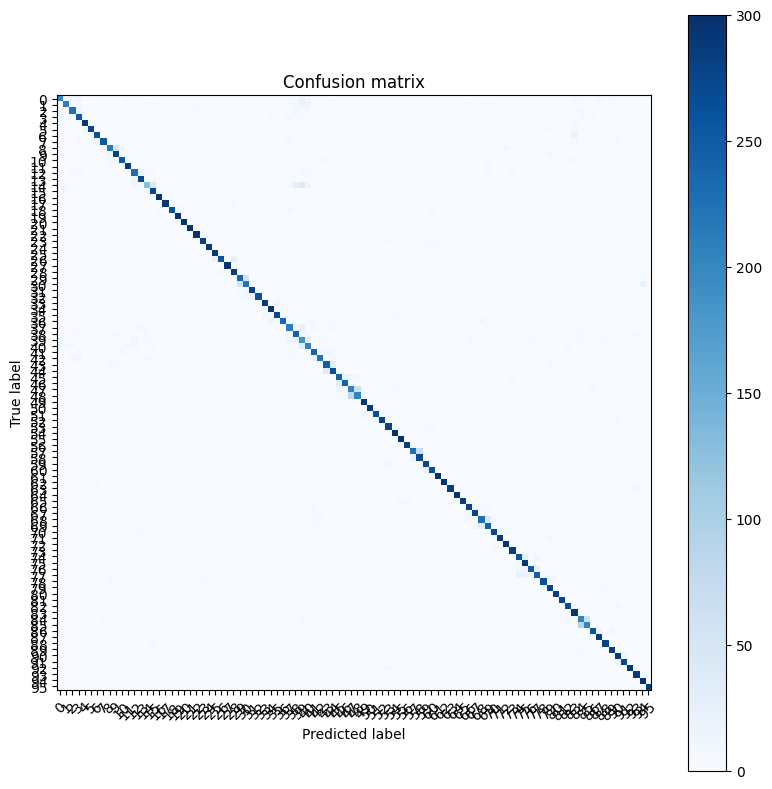

In [14]:
model = AuxResNet("resnet50", num_cluster=num_cluster, num_class=sum(num_classes), pretrained=False)
model.to(device)
model.eval()
ckpt = torch.load("records/auxiliary_ratio0.25_resnet50_lr_0.001_bs_64_pretrained/model_best.pth.tar", map_location=torch.device('cpu'))
model.load_state_dict(ckpt["state_dict"])
preds = []
for images in tqdm(loader):
    images = images.to(device)
    with torch.no_grad():
        output, _ = model(images)
        _, pred = torch.max(output, 1)
    preds += pred.cpu().detach().tolist()

preds = np.array(preds)
evaluator.add_batch(targets, preds)
print("#####  Two-Headed Model (ResNet50)  #####")
print("Accuracy : {}%".format(accuracy_score(targets, preds) * 100)) # 89.229%
# print(classification_report(targets, preds, target_names=class_names))
plot_confusion_matrix(evaluator.get_confusion_matrix())
del model, ckpt